# Intro to Object Detection Colab

Welcome to the object detection colab!  This demo will take you through the steps of running an "out-of-the-box" detection model on a collection of images.

## Imports and Setup

In [1]:
# !pip install -U --pre tensorflow=="2.2.0"

In [1]:
import os
# import pathlib

# # Clone the tensorflow models repository if it doesn't already exist
# if "models" in pathlib.Path.cwd().parts:
#     while "models" in pathlib.Path.cwd().parts:
#         os.chdir('..')
# elif not pathlib.Path('models').exists():
#     !git clone --depth 1 https://github.com/tensorflow/models

In [2]:
# Install the Object Detection API
# !cd models/research/
# !protoc object_detection/protos/*.proto --python_out=.
# !cp object_detection/packages/tf2/setup.py .
# !python -m pip install .

In [2]:
# import matplotlib
import matplotlib.pyplot as plt

# import io
# import scipy.misc
import numpy as np
# from six import BytesIO
# from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

2022-12-04 14:46:10.594327: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 14:46:10.739435: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-04 14:46:11.391583: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nashirj/miniconda3/lib/
2022-12-04 14:46:11.391693: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7:

## Utilities

In [3]:
import cv2

In [4]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: the file path to the image

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """
    # img_data = tf.io.gfile.GFile(path, 'rb').read()
    # image = Image.open(BytesIO(img_data))
    # (im_width, im_height) = image.size
    # return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    return image.reshape((image.shape[0], image.shape[1], 3)).astype(np.uint8)


In [5]:
# @title Choose the model to use, then evaluate the cell.
MODELS = {
    'centernet_with_keypoints': 'centernet_hg104_512x512_kpts_coco17_tpu-32',
    'centernet_without_keypoints': 'centernet_hg104_512x512_coco17_tpu-8',
    'mobile_centernet': 'centernet_mobilenetv2fpn_512x512_coco17_od'
}

model_display_name = 'centernet_without_keypoints' # 'centernet_with_keypoints' # @param ['centernet_with_keypoints', 'centernet_without_keypoints']
model_name = MODELS[model_display_name]

### Build a detection model and load pre-trained model weights

This sometimes takes a little while, please be patient!

In [9]:
# # Download the checkpoint and put it into models/research/object_detection/test_data/

# if model_display_name == 'centernet_with_keypoints':
#     !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_hg104_512x512_kpts_coco17_tpu-32.tar.gz
#     !tar -xf centernet_hg104_512x512_kpts_coco17_tpu-32.tar.gz
#     !mv centernet_hg104_512x512_kpts_coco17_tpu-32/checkpoint models/research/object_detection/test_data/
# else:
#     !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_hg104_512x512_coco17_tpu-8.tar.gz
#     !tar -xf centernet_hg104_512x512_coco17_tpu-8.tar.gz
#     !mv centernet_hg104_512x512_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

/usr/bin/zsh: /home/nashirj/miniconda3/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
--2022-12-04 11:27:17--  http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_hg104_512x512_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 2607:f8b0:4002:81a::2010, 64.233.176.128
Connecting to download.tensorflow.org (download.tensorflow.org)|2607:f8b0:4002:81a::2010|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1426100886 (1.3G) [application/x-tar]
Saving to: ‘centernet_hg104_512x512_coco17_tpu-8.tar.gz.1’

centernet_hg104_512 100%[===================>]   1.33G  19.1MB/s    in 74s     

2022-12-04 11:28:32 (18.4 MB/s) - ‘centernet_hg104_512x512_coco17_tpu-8.tar.gz.1’ saved [1426100886/1426100886]

/usr/bin/zsh: /home/nashirj/miniconda3/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
/usr/bin/zsh: /home/nashirj/miniconda3/lib/libtinfo.so.6: no version 

In [8]:
pipeline_config = 'models/research/object_detection/configs/tf2/centernet_hourglass104_512x512_coco17_tpu-8.config'
model_dir = 'models/research/object_detection/test_data/checkpoint/'

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(model_dir, 'ckpt-0')).expect_partial()

def get_model_detection_function(model):
    """Get a tf.function for detection."""

    @tf.function
    def detect_fn(image):
        """Detect objects in image."""

        image, shapes = model.preprocess(image)
        prediction_dict = model.predict(image, shapes)
        detections = model.postprocess(prediction_dict, shapes)

        return detections, prediction_dict, tf.reshape(shapes, [-1])

    return detect_fn

detect_fn = get_model_detection_function(detection_model)

2022-12-04 11:46:35.480729: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 11:46:35.521395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 11:46:35.521558: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 11:46:35.522846: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

# Load label map data (for plotting).

Label maps correspond index numbers to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine.

In [9]:
# label_map_path = configs['eval_input_config'].label_map_path
label_map_path = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

### Putting everything together!

Run the below code which loads an image, runs it through the detection model and visualizes the detection results, including the keypoints.

Note that this will take a long time (several minutes) the first time you run this code due to tf.function's trace-compilation --- on subsequent runs (e.g. on new images), things will be faster.

Here are some simple things to try out if you are curious:
* Try running inference on your own images (local paths work)
* Modify some of the input images and see if detection still works.  Some simple things to try out here (just uncomment the relevant portions of code) include flipping the image horizontally, or converting to grayscale (note that we still expect the input image to have 3 channels).
* Print out `detections['detection_boxes']` and try to match the box locations to the boxes in the image.  Notice that coordinates are given in normalized form (i.e., in the interval [0, 1]).
* Set min_score_thresh to other values (between 0 and 1) to allow more detections in or to filter out more detections.

Note that you can run this cell repeatedly without rerunning earlier cells.


In [13]:
image_path = 'nyc.jpeg'

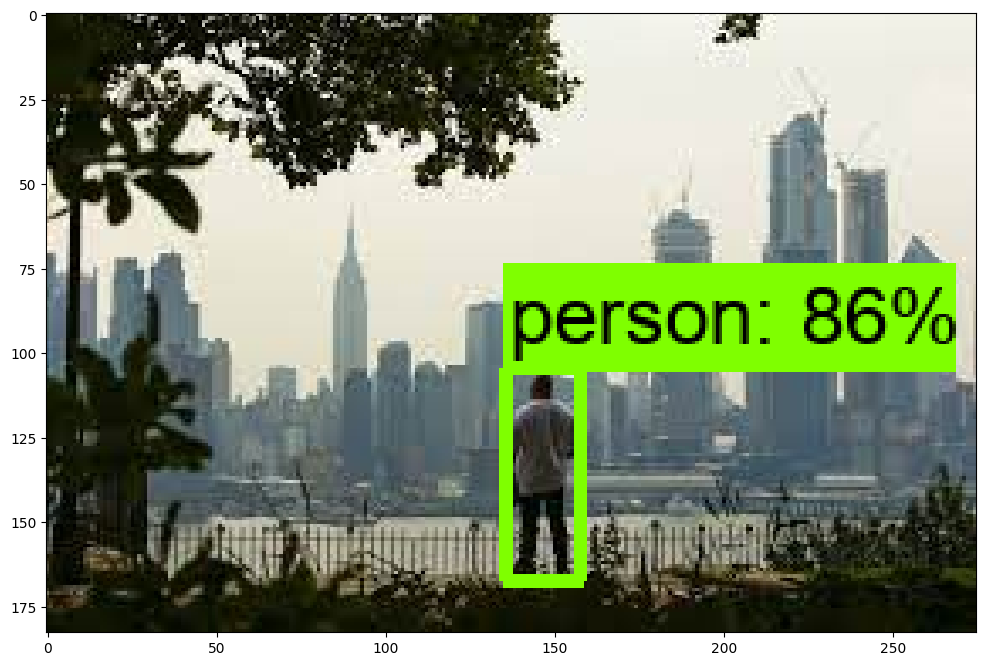

In [14]:
# image_dir = 'models/research/object_detection/test_images/'
# image_path = os.path.join(image_dir, 'image1.jpg')
image_np = load_image_into_numpy_array(image_path)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False)
      # keypoints=keypoints,
      # keypoint_scores=keypoint_scores,
      # keypoint_edges=get_keypoint_tuples(configs['eval_config']))

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()

## Digging into the model's intermediate predictions

For this part we will assume that the detection model is a CenterNet model following Zhou et al (https://arxiv.org/abs/1904.07850).  And more specifically, we will assume that `detection_model` is of type `meta_architectures.center_net_meta_arch.CenterNetMetaArch`.

As one of its intermediate predictions, CenterNet produces a heatmap of box centers for each class (for example, it will produce a heatmap whose size is proportional to that of the image that lights up at the center of each, e.g., "zebra"). In the following, we will visualize these intermediate class center heatmap predictions.

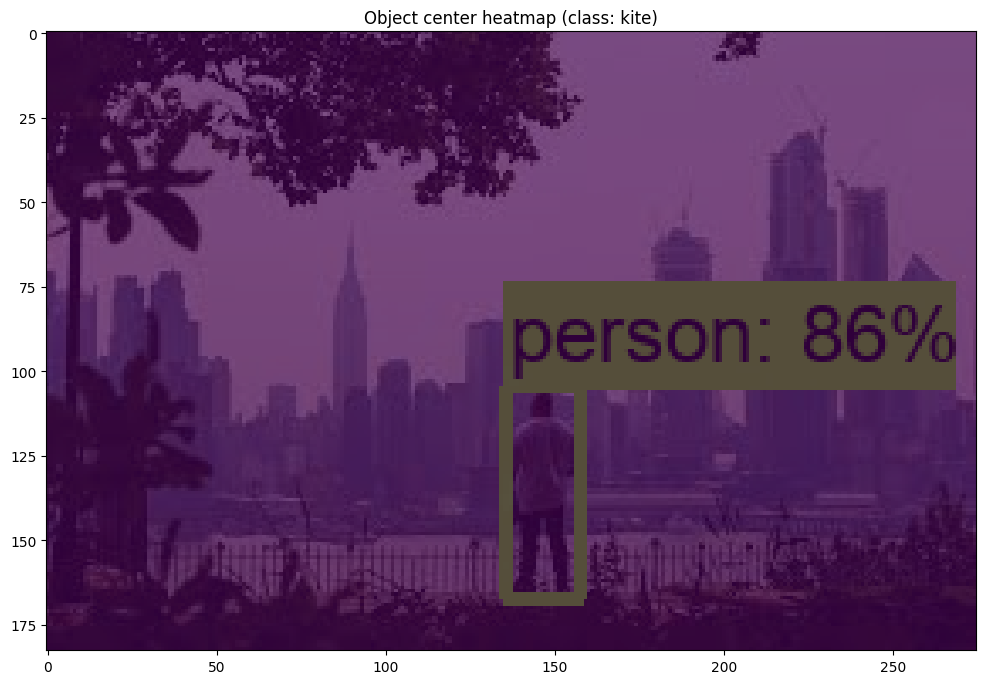

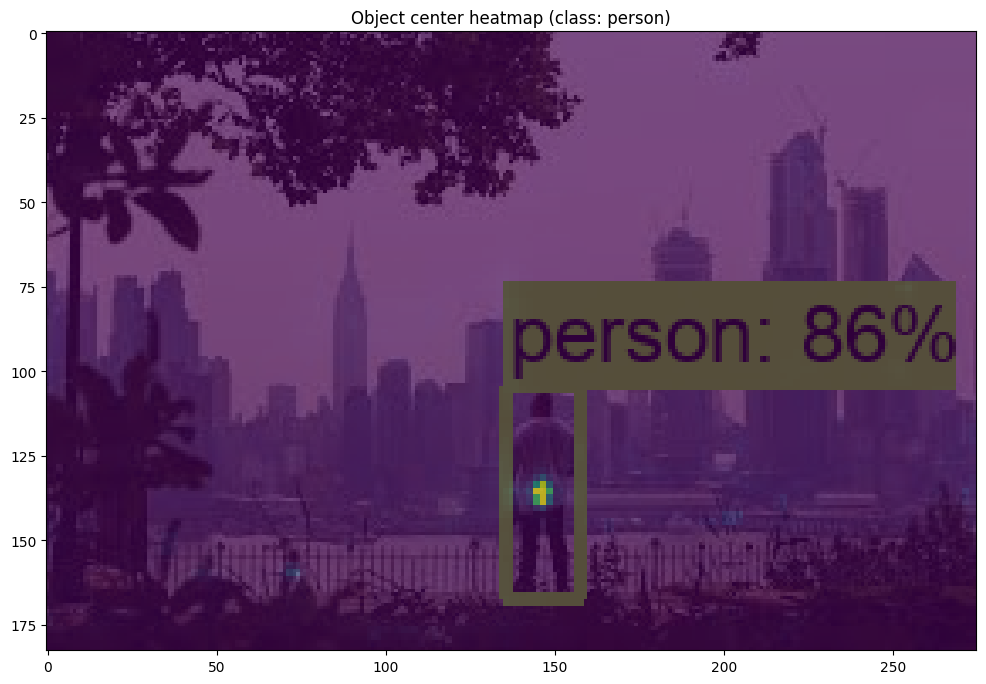

In [15]:
# if detection_model.__class__.__name__ != 'CenterNetMetaArch':
#     raise AssertionError('The meta-architecture for this section '
#     'is assumed to be CenterNetMetaArch!')

# def get_heatmap(predictions_dict, class_name):
#     """Grabs class center logits and apply inverse logit transform.

#     Args:
#     predictions_dict: dictionary of tensors containing a `object_center`
#       field of shape [1, heatmap_width, heatmap_height, num_classes]
#     class_name: string name of category (e.g., `horse`)

#     Returns:
#     heatmap: 2d Tensor heatmap representing heatmap of centers for a given class
#       (For CenterNet, this is 128x128 or 256x256) with values in [0,1]
#     """
#     class_index = label_map_dict[class_name]
#     class_center_logits = predictions_dict['object_center'][0]
#     class_center_logits = class_center_logits[0][:, :, class_index - label_id_offset]
#     heatmap = tf.exp(class_center_logits) / (tf.exp(class_center_logits) + 1)
#     return heatmap

# def unpad_heatmap(heatmap, image_np):
#     """Reshapes/unpads heatmap appropriately.

#     Reshapes/unpads heatmap appropriately to match image_np.

#     Args:
#     heatmap: Output of `get_heatmap`, a 2d Tensor
#     image_np: uint8 numpy array with shape (img_height, img_width, 3).  Note
#       that due to padding, the relationship between img_height and img_width
#       might not be a simple scaling.

#     Returns:
#     resized_heatmap_unpadded: a resized heatmap (2d Tensor) that is the same
#       size as `image_np`
#     """
#     heatmap = tf.tile(tf.expand_dims(heatmap, 2), [1, 1, 3]) * 255
#     pre_strided_size = detection_model._stride * heatmap.shape[0]
#     resized_heatmap = tf.image.resize(
#       heatmap, [pre_strided_size, pre_strided_size],
#       method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
#     resized_heatmap_unpadded = tf.slice(resized_heatmap, begin=[0,0,0], size=shapes)
#     return tf.image.resize(
#       resized_heatmap_unpadded,
#       [image_np.shape[0], image_np.shape[1]],
#       method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)[:,:,0]


# class_name = 'kite'
# heatmap = get_heatmap(predictions_dict, class_name)
# resized_heatmap_unpadded = unpad_heatmap(heatmap, image_np)
# plt.figure(figsize=(12,16))
# plt.imshow(image_np_with_detections)
# plt.imshow(resized_heatmap_unpadded, alpha=0.7,vmin=0, vmax=160, cmap='viridis')
# plt.title('Object center heatmap (class: ' + class_name + ')')
# plt.show()

# class_name = 'person'
# heatmap = get_heatmap(predictions_dict, class_name)
# resized_heatmap_unpadded = unpad_heatmap(heatmap, image_np)
# plt.figure(figsize=(12,16))
# plt.imshow(image_np_with_detections)
# plt.imshow(resized_heatmap_unpadded, alpha=0.7,vmin=0, vmax=160, cmap='viridis')
# plt.title('Object center heatmap (class: ' + class_name + ')')
# plt.show()